#Task-1: Data Loading

In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Social_Network_Ads.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rakeshrau/social-network-ads",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

display("First 5 records:", df.head())
display("Last 5 records:", df.tail())

print("The shape of the data")
display(df.shape)

/tmp/ipython-input-3041035459.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'social-network-ads' dataset.


'First 5 records:'

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


'Last 5 records:'

,User ID,Gender,Age,EstimatedSalary,Purchased
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0
399,15594041,Female,49,36000,1


The shape of the data


(400, 5)

# Task-2: Data Preprocessing

In [2]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

## 2.1 Missing Values check

In [3]:
print('Missing values per column:')
display(df.isnull().sum())

print('\nTotal missing values in the DataFrame:')
display(df.isnull().sum().sum())

# drop user Id
df = df.drop('User ID', axis=1)

Missing values per column:


,0
User ID,0
Gender,0
Age,0
EstimatedSalary,0
Purchased,0



Total missing values in the DataFrame:


np.int64(0)

### comment:
As no missing value, no missing value handling is needed <br>
user Id has been dropped as it is not required

## 2.2 Feature Engineering

In [4]:
# Feature engineering

# Age bin
# Binning Age into categories (Young, Middle, Old)\
df_engineered = df.copy()
df_engineered["Age_bin"] = pd.cut(
    df_engineered["Age"],
    bins=[0,25,35,45,100],
    labels=["Young", "Middle", "Mature", "Old"]
)
#print(df[["Age", "Age_bin"]].head(5))
df_engineered = df_engineered.drop("Age", axis=1)
df_engineered.head()

,Gender,EstimatedSalary,Purchased,Age_bin
0,Male,19000,0,Young
1,Male,20000,0,Middle
2,Female,43000,0,Middle
3,Female,57000,0,Middle
4,Male,76000,0,Young


We jsut added the age bin as feature engineering

## 2.3 Encoding

fist cassify the col types

In [5]:
# Separate cols
# Numerical cols
numerical_cols = ["EstimatedSalary"]

# Categorical cols
categorical_cols = ["Gender", "Age_bin"]

# Binary categorical columns
binary_categorical_cols = ["Gender"]

# Target col
target_col = "Purchased"

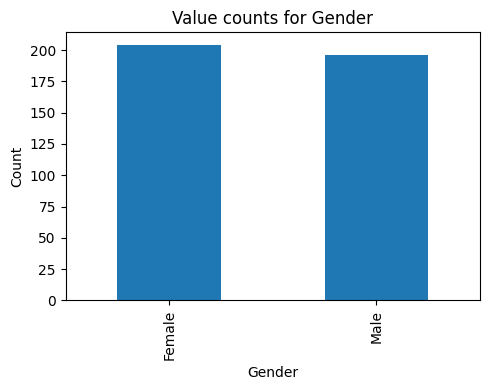

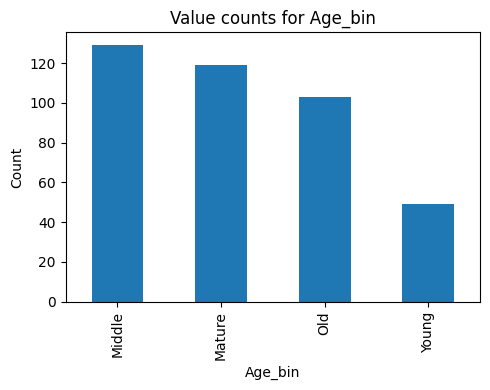

In [6]:
for c in categorical_cols:
  plt.figure(figsize=(5,4))
  df_engineered[c].value_counts().plot(kind="bar")
  plt.title(f"Value counts for {c}")
  plt.ylabel("Count")
  plt.tight_layout()
  plt.show()

In [7]:
# Label Encoding for binary categorical columns -> Sex and ExerciseAngina
le = LabelEncoder()
for bin_cat_col in binary_categorical_cols:
  df_engineered[bin_cat_col] = le.fit_transform(df_engineered[bin_cat_col])

# for sex: M -> 1, F -> 0

# One hot encoding
# OneHot Encoding for nominal categorical columns

df_encoded = pd.get_dummies(
    df_engineered,
    columns = categorical_cols,
    dtype=int
)
display(df_encoded.head())
display(df_engineered.head())

,EstimatedSalary,Purchased,Gender_0,Gender_1,Age_bin_Young,Age_bin_Middle,Age_bin_Mature,Age_bin_Old
0,19000,0,0,1,1,0,0,0
1,20000,0,0,1,0,1,0,0
2,43000,0,1,0,0,1,0,0
3,57000,0,1,0,0,1,0,0
4,76000,0,0,1,1,0,0,0


,Gender,EstimatedSalary,Purchased,Age_bin
0,1,19000,0,Young
1,1,20000,0,Middle
2,0,43000,0,Middle
3,0,57000,0,Middle
4,1,76000,0,Young


In [8]:
df_engineered.head()

,Gender,EstimatedSalary,Purchased,Age_bin
0,1,19000,0,Young
1,1,20000,0,Middle
2,0,43000,0,Middle
3,0,57000,0,Middle
4,1,76000,0,Young


## 2.4 Scaling

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# define input (features = X), output(target = y)
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)


scaler_sd = StandardScaler()
X_train_std = scaler_sd.fit_transform(X_train) # mean and SD will be calcualted from X_train and then apply to X_train
X_test_std = scaler_sd.transform(X_test) # the calculated mean and SD (From X_train) will be applied to X_test

X_train_std_df = pd.DataFrame(X_train_std, columns = X_train.columns, index = X_train.index)

X_train_std.shape, X_test_std.shape

((300, 7), (100, 7))

Standard scaler is used

## 2.5 Outliar detection

figure to see outliars

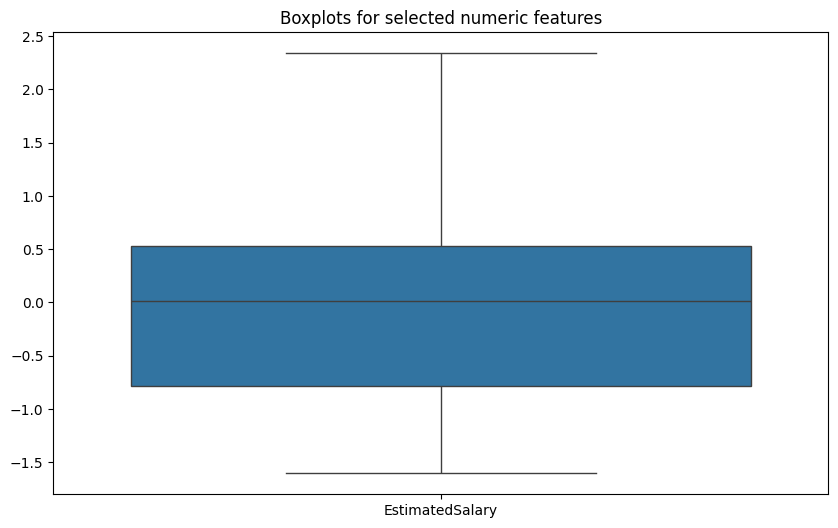

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train_std_df[numerical_cols])
plt.title("Boxplots for selected numeric features")
plt.show()

IQR method to see outliars

In [11]:
# Use IQR method on Numerical cols
for col in numerical_cols:
    Q1 = X_train_std_df[col].quantile(0.25)
    Q3 = X_train_std_df[col].quantile(0.75)
    IQR = Q3-Q1

    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    outliers = X_train_std_df[(X_train_std_df[col]<lower) | (X_train_std_df[col]>upper)]
    print(f"Numer of detected outliers in {col}: ", len(outliers))

Numer of detected outliers in EstimatedSalary:  0


So, no outliars detected

In [12]:
X_train_std_df

,EstimatedSalary,Gender_0,Gender_1,Age_bin_Young,Age_bin_Middle,Age_bin_Mature,Age_bin_Old
247,1.521894,0.986754,-0.986754,-0.357519,-0.696526,-0.680746,1.763403
110,0.032132,0.986754,-0.986754,-0.357519,-0.696526,1.468977,-0.567085
16,-1.311575,-1.013423,1.013423,-0.357519,-0.696526,-0.680746,1.763403
66,-1.486841,-1.013423,1.013423,2.797057,-0.696526,-0.680746,-0.567085
153,-0.581299,0.986754,-0.986754,-0.357519,-0.696526,1.468977,-0.567085
...,...,...,...,...,...,...,...
71,-1.253153,0.986754,-0.986754,2.797057,-0.696526,-0.680746,-0.567085
106,-1.019465,0.986754,-0.986754,-0.357519,1.435697,-0.680746,-0.567085
270,1.843215,0.986754,-0.986754,-0.357519,-0.696526,1.468977,-0.567085
348,0.207398,-1.013423,1.013423,-0.357519,-0.696526,1.468977,-0.567085


#3. Pipeline Creation

split the data

In [13]:
from sklearn.model_selection import train_test_split

X = df[['Gender', 'Age', 'EstimatedSalary']]

# target variable
y = df['Purchased']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (300, 3)
Shape of X_test: (100, 3)
Shape of y_train: (300,)
Shape of y_test: (100,)


MAke a function to create age bins

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgeBinner(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['Age_bin'] = pd.cut(
            X_copy['Age'],
            bins=[0, 25, 35, 45, 100],
            labels=['Young', 'Middle', 'Mature', 'Old'],
            right=True # This ensures 25 goes to Middle, 35 to Mature, etc.
        )
        X_copy = X_copy.drop('Age', axis=1)
        return X_copy

print("AgeBinner class defined successfully.")

AgeBinner class defined successfully.


Pipeline OHE, standard scaler, and age binner

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature types
numerical_features = ['EstimatedSalary']
onehot_features = ['Gender', 'Age_bin']

# Create the ColumnTransformer for numerical scaling and categorical one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_features)
    ],
    remainder='passthrough'
)

# Construct the full preprocessing pipeline
full_preprocessing_pipeline = Pipeline(steps=[
    ('age_binner', AgeBinner()), # Custom transformer for age binning
    ('preprocessor', preprocessor) # ColumnTransformer for scaling and encoding
])

print("full_preprocessing_pipeline created successfully.")

full_preprocessing_pipeline created successfully.


Models

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Instantiate the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVC': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=200),
    'XGBoost': XGBClassifier(random_state=42)
}


set and train the model using pipeline

In [17]:
from sklearn.pipeline import Pipeline

pipelines = {}

for name, model in models.items():
    # Create a pipeline that includes preprocessing and the model
    full_pipeline = Pipeline(steps=[
        ('preprocessor', full_preprocessing_pipeline),
        ('classifier', model)
    ])
    pipelines[name] = full_pipeline

    # Train the pipeline
    print(f"Training {name}...")
    full_pipeline.fit(X_train, y_train)
    print(f"{name} trained successfully.")

print("All model pipelines created and trained successfully.")

Training Logistic Regression...
Logistic Regression trained successfully.
Training SVC...
SVC trained successfully.
Training Random Forest...
Random Forest trained successfully.
Training XGBoost...
XGBoost trained successfully.
All model pipelines created and trained successfully.


predict using pipeline and measure performance

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

results = []

for name, pipeline in pipelines.items():


    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

results_df = pd.DataFrame(results)

display("Model Evaluation Results:", results_df.sort_values(by='ROC-AUC', ascending=False))


'Model Evaluation Results:'

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
1,SVC,0.93,0.875000,0.945946,0.909091,0.985414
0,Logistic Regression,0.94,0.942857,0.891892,0.916667,0.984127
2,Random Forest,0.87,0.875000,0.756757,0.811594,0.960103
3,XGBoost,0.88,0.857143,0.810811,0.833333,0.953668


#4. Primary Model Selection

Selectred model: **SVC**

**Reason:** <br>
1. Best Recall (0.946)
2. Second Best Accuracy (93%)
4. Second Best f1 Score (0.91)
5. Great ROC- AUC (0.98)

The SVC model is selected for its value on the Recall score.
This ad campaign dont want to loose actual customers. So a high recall score is needed
<br>***Recall = “Out of all people who would buy, how many did we catch?”*** <br>which is the most important metric in the campaign


#5. Model Training

THough the model is trained before in the pipeline phase.
We retrain the model and get the accuracy.

The model is brought from the pipelines itself.

In [19]:
svc_retrain = pipelines['SVC']
print("Re-training SVC pipeline...")
svc_retrain.fit(X_train, y_train)
print("SVC pipeline re-trained successfully.")

Re-training SVC pipeline...
SVC pipeline re-trained successfully.


In [20]:
# measure accuracy
from sklearn.metrics import accuracy_score
y_pred = svc_retrain.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.93


#6. Cross validation

In [28]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the retrained SVC model
cv_scores = cross_val_score(svc_retrain, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores (accuracy):")
display(cv_scores)

print("Mean CV accuracy:", cv_scores.mean())
print("Standard deviation of CV accuracy:", cv_scores.std())

Cross-validation scores (accuracy):


array([0.88333333, 0.93333333, 0.88333333, 0.81666667, 0.88333333])

Mean CV accuracy: 0.8800000000000001
Standard deviation of CV accuracy: 0.037118429085533484


Here the scoring is done on accuracy
The mean CV accuracy is 0.88
and standart deviation of CV accuracy is 0.037

#7. Hyper parameter tuning

In [29]:
from sklearn.model_selection import GridSearchCV

svc_pipeline = pipelines['SVC']


param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf', 'linear']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    svc_pipeline,
    param_grid,
    cv=5, # Using 5-fold cross-validation
    scoring='accuracy', # Optimize for accuracy
    n_jobs=-1, # Use all available cores
    verbose=2
)

print("Performing GridSearchCV...")
# Train
grid_search.fit(X_train, y_train)

print("GridSearchCV completed.")

# best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


best_svc_model = grid_search.best_estimator_
print("Best SVC model:", best_svc_model)

Performing GridSearchCV...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
GridSearchCV completed.
Best parameters found: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Best cross-validation accuracy: 0.8866666666666667
Best SVC model: Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('age_binner', AgeBinner()),
                                 ('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['EstimatedSalary']),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                   

I optimized an SVM classification pipeline using GridSearchCV with five-fold cross-validation to identify the best hyperparameters that maximize model accuracy on the training dataset.


# 8. Best Model Selection

The best performing SVC model is:

     

```python
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('age_binner', AgeBinner()),
                                 ('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['EstimatedSalary']),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Gender',
                                                                    'Age_bin'])]))])),
                ('classifier',
                 SVC(C=10, gamma='auto', probability=True, random_state=42))])
```



In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

# Assuming AgeBinner is defined in the notebook
# If not, you might need to re-execute the cell where it's defined.

best_model = Pipeline(steps=[
    ('preprocessor',
     Pipeline(steps=[
         ('age_binner', AgeBinner()),
         ('preprocessor',
          ColumnTransformer(remainder='passthrough',
                            transformers=[
                                ('num',
                                 StandardScaler(),
                                 ['EstimatedSalary']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore', sparse_output=False),
                                 ['Gender',
                                  'Age_bin'])]))])),
    ('classifier',
     SVC(C=10, gamma='auto', probability=True, random_state=42))
])

print("Best model defined and stored in 'best_model' variable.")

Best model defined and stored in 'best_model' variable.


# 9. Model Performance Evaluation

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Fit best model
print("Fitting the best model...")
best_model.fit(X_train, y_train)
print("Best model fitted successfully.")

# Make predictions
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Metics
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

# results
results_best_model = {
    'Model': 'Best SVC (Tuned)',
    'Accuracy': accuracy_best,
    'Precision': precision_best,
    'Recall': recall_best,
    'F1-Score': f1_best,
    'ROC-AUC': roc_auc_best
}

display(pd.DataFrame([results_best_model]))

Fitting the best model...
Best model fitted successfully.


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Best SVC (Tuned),0.93,0.875,0.945946,0.909091,0.979408
